# Computer Vision 2022 Assignment 2: Image matching and retrieval

In this assignment, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the assignment:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

This assignment will have a minimum hurdle of 40%. You will fail if you can not reach the minimum hurdle.

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'
    # Or
    jupyter nbconvert Assignment2.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

**Please do try this ccommond early before the last day! As the commend may be a little bit difference depending on your computer and the environment.**

This will also remove the preamble text from each question. We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

This being the second assignment, we have provided less strict direction this time and you have more flexibility to choose how you answer each question. However you still need to ensure the outputs and report are clear and easy to read. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. Within each category, there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [60]:
# Numpy is the main package for scientific computing with Python. 
import numpy as np
import cv2

# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
def draw_outline(ref, query, model):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h,w = ref.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,model)
    

    return dst
    
    img = query.copy()
    img = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)
    # print(img.shape)

    plt.axis('off')
    plt.title('draw outline')
    plt.imshow(img, 'gray')
    plt.show()  
    

def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography() 
    """
    matchesMask = matchesMask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)
    
    return img3


# Matching an object in a pair of images (45%)

### draw key points and macthes by using orb method

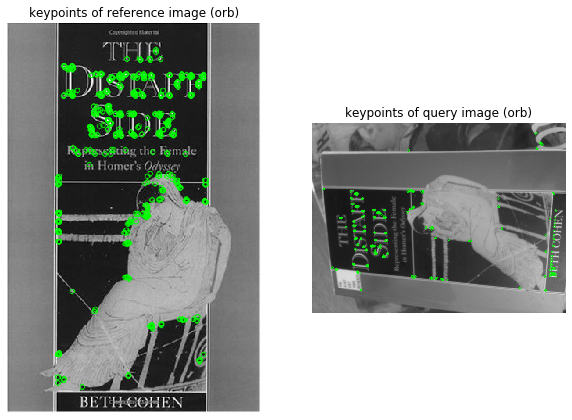

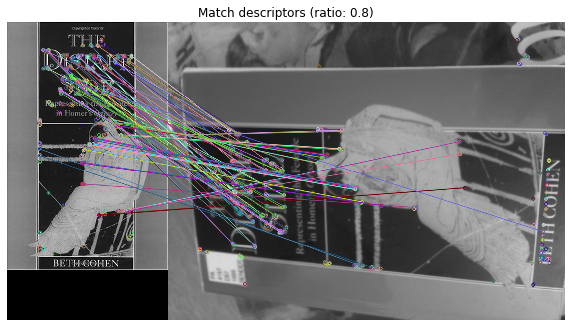

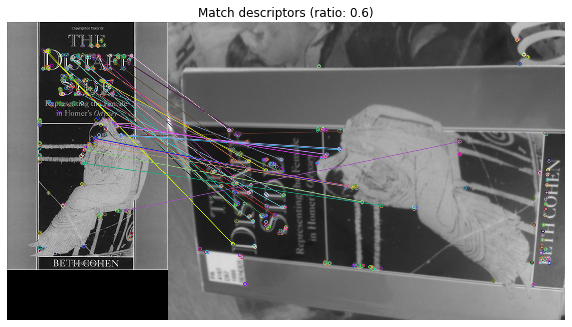

In [121]:
# Your code for descriptor matching tests here

# load image at gray scale
img1 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference/001.jpg', 0)
img2 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/001.jpg', 0)
color_query = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/001.jpg')

# compute detector and descriptor
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# draw keypoints
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

reference_image = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)

ax1.imshow(reference_image)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')

plt.show()

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Match descriptors.
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
good_without_list = []
for m,n in matches:
    if m.distance < 0.8 * n.distance:
        good.append([m])  
        good_without_list.append(m)

# draw matches
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None)

plt.title('Match descriptors (ratio: 0.8)')
plt.axis('off')
plt.imshow(img3)
plt.show()

# Apply ratio test
good1 = []
good1_without_list = []
for m,n in matches:
    if m.distance < 0.6 * n.distance:
        good1.append([m])  
        good1_without_list.append(m)

img4 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good1, None)
    

plt.title('Match descriptors (ratio: 0.6)')
plt.axis('off')
plt.imshow(img4)
plt.show()


**Change the ratio**

By compare the ration 0.6 and the rtatio  0.8, we can get:

- when the ratio become small, the keypoints and match numbers become less.
- when the ratio become large, the keypoints and match numbers become more.


***

### draw outline and inliers by using regular method

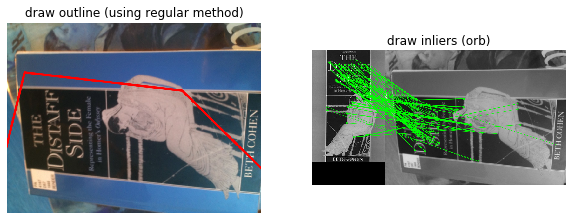

number of detected inliers:  131
number of detected outliers:  0.0


In [122]:
# Your code to display book location here

# using  (orb ( asdasdasdasdasd(cv2.findHomography)
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

# draw inliers
inliers_sift = draw_inliers(img1, img2, kp1, kp2, good_without_list, matchesMask)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_sift)
ax1.set_axis_off()
ax1.set_title('draw outline (using regular method)')

ax2.imshow(inliers_sift)
ax2.set_axis_off()
ax2.set_title('draw inliers (orb)')

plt.show()


inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)

***Summary***

When I try to use regular method, I notice draw oulines does not work correctly. 

***

### Draw outline and inliers by using RANSAC

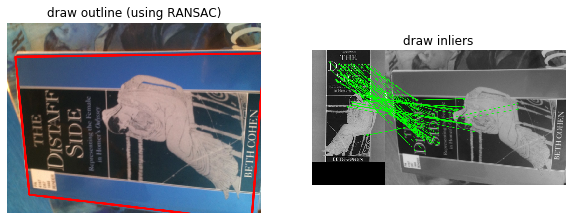

number of detected inliers:  100
number of detected outliers:  31.0


In [123]:
# Your code to display book location after RANSAC here
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

# draw inliers
inliers_sift = draw_inliers(img1, img2, kp1, kp2, good_without_list, matchesMask)

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_sift)
ax1.set_axis_off()
ax1.set_title('draw outline (using RANSAC)')

ax2.imshow(inliers_sift)
ax2.set_axis_off()
ax2.set_title('draw inliers')

plt.show()




inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)

***Summary***

Compare to the RANSAC and the regular method, I notice the number of dectected inliers is different. The ***total number of detected points are 131***, and when I use ***RANSAC*** method, the number of detected inliers are ***only 100***, however, when I use ***regular method***, the number of detected inliers are ***131***. There is ***a difference of 31 points***. However, it may influence when draw outlines because these 31 points should not be caculated in the inliers.

***

In [65]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

## Book cover (example book_cover_025)

### draw keypoints of reference image and query image (using orb, brisk and sift)

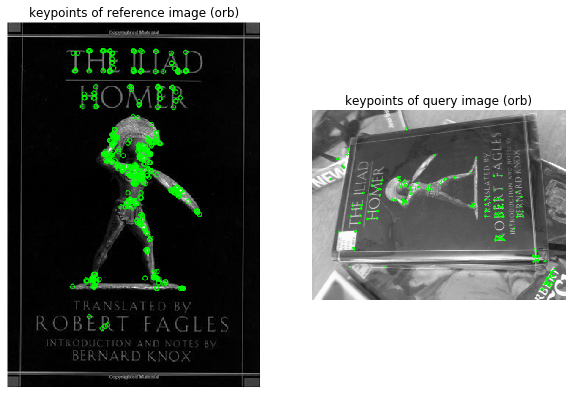

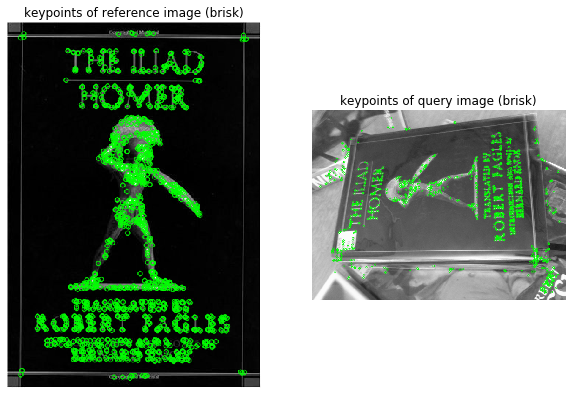

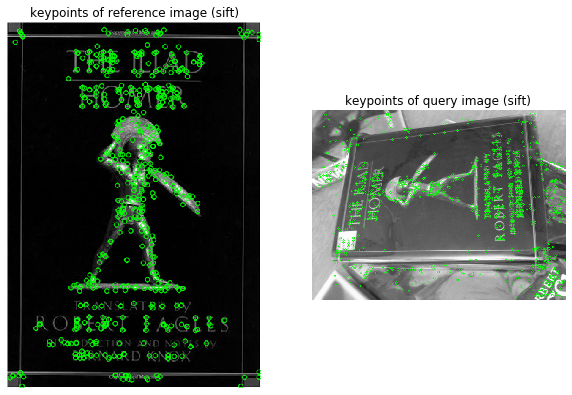

In [109]:
# load image at gray scale
img1 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference/025.jpg', 0)
img2 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/025.jpg', 0)
# img1 = cv2.add(img1, 20)
# img2 = cv2.add(img2, 20)
color_query = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/025.jpg')


# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image_orb)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')


# use brisk
kp5, des5 = detectAndDescribe(img1, 'brisk')
kp6, des6 = detectAndDescribe(img2, 'brisk')

reference_image_brisk = cv2.drawKeypoints(img1, kp5, des5, color=(0,255,0), flags=0)
query_image_brisk = cv2.drawKeypoints(img2, kp6, des6, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_brisk)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (brisk)')

ax2.imshow(query_image_brisk)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (brisk)')


# use sift
kp3, des3 = detectAndDescribe(img1, 'sift')
kp4, des4 = detectAndDescribe(img2, 'sift')

reference_image_sift = cv2.drawKeypoints(img1, kp3, des3, color=(0,255,0), flags=0)
query_image_sift = cv2.drawKeypoints(img2, kp4, des4, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_sift)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (sift)')

ax2.imshow(query_image_sift)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (sift)')


plt.show()

### summary of finding key ponits part

In **getting keypoints**, the shift and brisk are working better than orb, it returns more key points in the query image and the reference image.

In [110]:
def createMatcher(method):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    return bf

***

### Draw match part (using orb and sift)

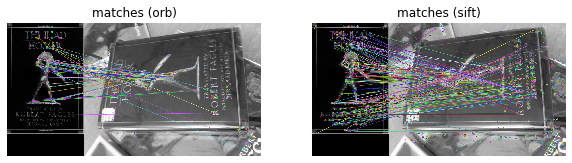

In [111]:
bf_orb = createMatcher('orb')
bf_sift = createMatcher('sift')

matches_orb = bf_orb.knnMatch(des1, des2, k=2) 
matches_sift = bf_sift.knnMatch(des3, des4, k=2) 

# Apply ratio test (orb)
good_orb = []
good_orb_without_list = []
for m,n in matches_orb:
    if m.distance < 0.8 * n.distance:
        good_orb.append([m])
        good_orb_without_list.append(m)

# Apply ratio test (sift)
good_sift = []
good_sift_without_list = []
for m,n in matches_sift:
    if m.distance < 0.8 * n.distance:
        good_sift.append([m])
        good_sift_without_list.append(m)

# draw matches
matches_orb = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_orb, None)
matches_sift = cv2.drawMatchesKnn(img1, kp3, img2, kp4, good_sift, None)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(matches_orb)
ax1.set_axis_off()
ax1.set_title('matches (orb)')

ax2.imshow(matches_sift)
ax2.set_axis_off()
ax2.set_title('matches (sift)')


plt.show()

### Summary of drawing match part

In this part, I notice some macthes in ***orb method*** matches the keypoints ***outside the reference book***, which are ***wrong matches***. (shown in the picture: wrong matches)

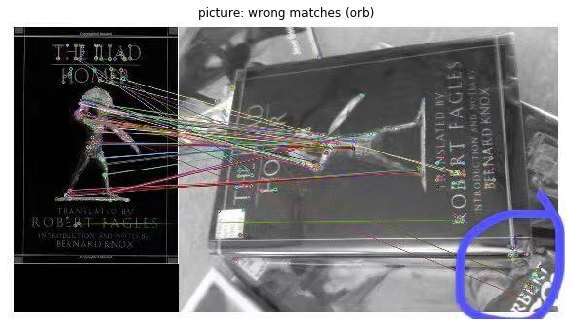

In [69]:
img = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/WechatIMG54.jpeg')

plt.axis('off')
plt.title('picture: wrong matches (orb)')
plt.imshow(img)
plt.show()

***

### Draw outlines and inliers (using orb)

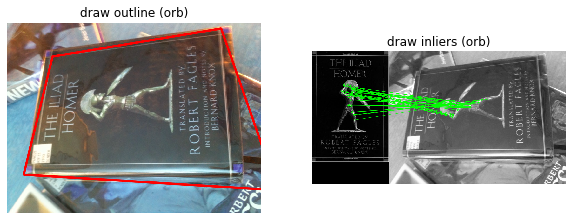

number of detected inliers:  57
number of detected outliers:  36.0
Ratio:  0.6129032258064516


In [112]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_orb = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)


# draw inliers
inliers_orb = draw_inliers(img1, img2, kp1, kp2, good_orb_without_list, matchesMask)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_orb)
ax1.set_axis_off()
ax1.set_title('draw outline (orb)')

ax2.imshow(inliers_orb)
ax2.set_axis_off()
ax2.set_title('draw inliers (orb)')


plt.show()


inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Draw outlines and inliers (using sift)

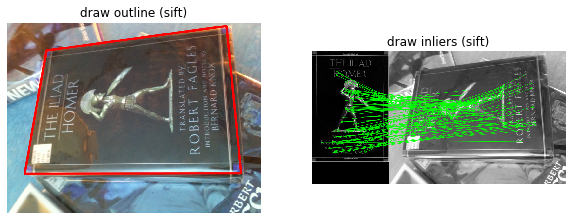

number of detected inliers:  106
number of detected outliers:  70.0
Ratio:  0.6022727272727273


In [113]:
src_pts = np.float32([kp3[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp4[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)


# draw inliers
inliers_sift = draw_inliers(img1, img2, kp3, kp4, good_sift_without_list, matchesMask)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_sift)
ax1.set_axis_off()
ax1.set_title('draw outline (sift)')

ax2.imshow(inliers_sift)
ax2.set_axis_off()
ax2.set_title('draw inliers (sift)')


plt.show()


inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Summary

In image 25 from book_covers. we can see when we use orb method to get the outline, it is not very precise, however, sift method works good.

***Reason (why orb method will fail)***: 
when I use orb method, the keypoints of query image do not detect many keypoints in this area (draw in the picture_01), the key points which are detected are focus on the person (middle in the book cover). So when do matches, some keypoints which outside the book cover may interfere with drawing outlines, this is why we can not get the correct area when we draw outlines.


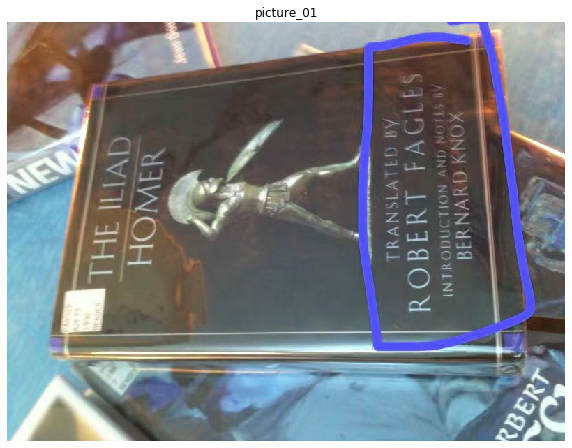

In [72]:
img = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/book_cover025.jpeg')

plt.axis('off')
plt.title('picture_01')
plt.imshow(img)
plt.show()

***

### Little improvement

***However, changing the brightness of the image can solve this problem (wrong outline with orb).***

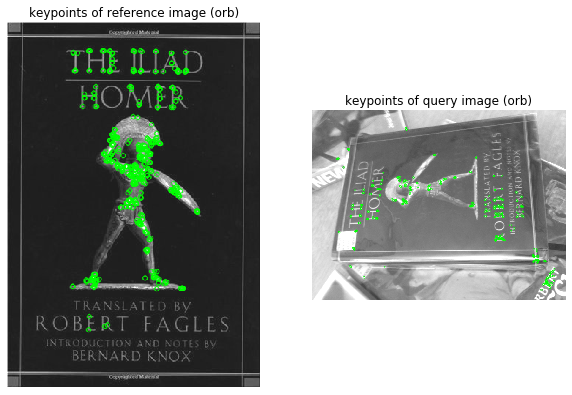

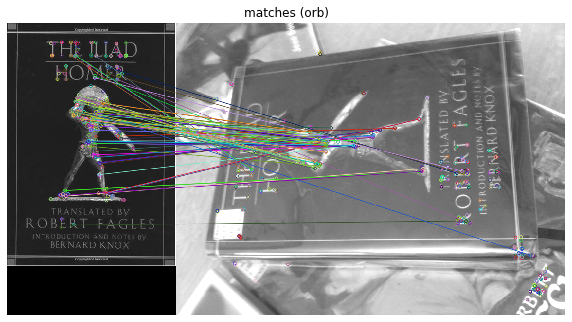

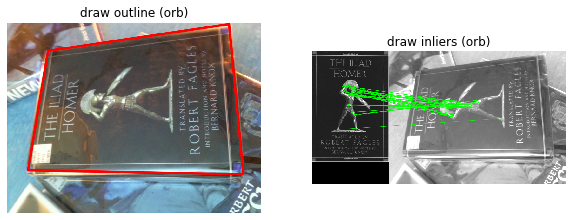

number of detected inliers:  52
number of detected outliers:  34.0
Ratio:  0.6046511627906976


In [119]:
img1 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference/025.jpg', 0)
img2 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/025.jpg', 0)
img1 = cv2.add(img1, 30)
img2 = cv2.add(img2, 30)
color_query = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/025.jpg')


# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image_orb)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')


plt.show()

bf_orb = createMatcher('orb')
bf_sift = createMatcher('sift')

matches_orb = bf_orb.knnMatch(des1, des2, k=2) 
matches_sift = bf_sift.knnMatch(des3, des4, k=2) 

# Apply ratio test (orb)
good_orb = []
good_orb_without_list = []
for m,n in matches_orb:
    if m.distance < 0.8 * n.distance:
        good_orb.append([m])
        good_orb_without_list.append(m)

# Apply ratio test (sift)
good_sift = []
good_sift_without_list = []
for m,n in matches_sift:
    if m.distance < 0.8 * n.distance:
        good_sift.append([m])
        good_sift_without_list.append(m)

# draw matches
matches_orb = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_orb, None)

plt.title('matches (orb)')
plt.axis('off')
plt.imshow(matches_orb)
plt.show()

src_pts = np.float32([kp1[m.queryIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_orb = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)


# draw inliers
inliers_orb = draw_inliers(img1, img2, kp1, kp2, good_orb_without_list, matchesMask)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_orb)
ax1.set_axis_off()
ax1.set_title('draw outline (orb)')

ax2.imshow(inliers_orb)
ax2.set_axis_off()
ax2.set_title('draw inliers (orb)')

plt.show()




inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

We can see that when we change the brightness **(using cv2.add(image, 30) and set the value to 30)**, it makes orb method be more accurate and get a correct outline. 

***

## museum paintings (example museum_paintings_064)

### draw keypoints of reference image and query image (using orb, brisk and sift)

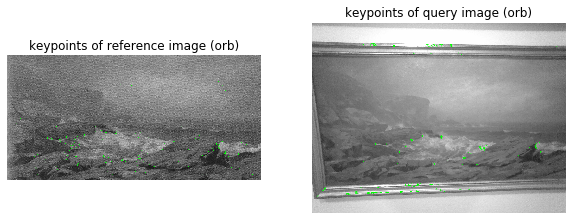

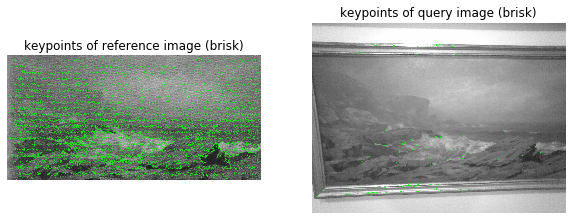

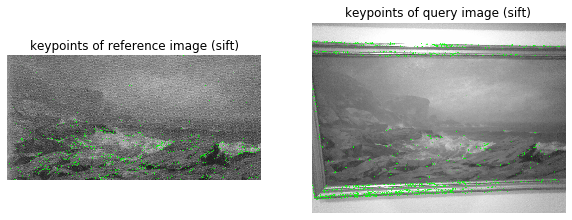

In [187]:
# load image at gray scale
img1 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/museum_paintings/Reference/064.jpg', 0)
img2 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/museum_paintings/Query/064.jpg', 0)
color_query = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/museum_paintings/Query/064.jpg')


# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image_orb)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')


# use brisk
kp5, des5 = detectAndDescribe(img1, 'brisk')
kp6, des6 = detectAndDescribe(img2, 'brisk')

reference_image_brisk = cv2.drawKeypoints(img1, kp5, des5, color=(0,255,0), flags=0)
query_image_brisk = cv2.drawKeypoints(img2, kp6, des6, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_brisk)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (brisk)')

ax2.imshow(query_image_brisk)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (brisk)')


# use sift
kp3, des3 = detectAndDescribe(img1, 'sift')
kp4, des4 = detectAndDescribe(img2, 'sift')

reference_image_sift = cv2.drawKeypoints(img1, kp3, des3, color=(0,255,0), flags=0)
query_image_sift = cv2.drawKeypoints(img2, kp4, des4, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_sift)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (sift)')

ax2.imshow(query_image_sift)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (sift)')


plt.show()

### summary of finding key ponits part

In **getting keypoints**, the shift and brisk are working better than orb, it returns more key points in the query image and the reference image.

***

### Draw match part (using orb and sift)

In [75]:
def createMatcher(method):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    return bf

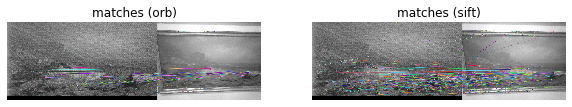

In [188]:
bf_orb = createMatcher('orb')
bf_sift = createMatcher('sift')

matches_orb = bf_orb.knnMatch(des1, des2, k=2) 
matches_sift = bf_sift.knnMatch(des3, des4, k=2) 

# Apply ratio test (orb)
good_orb = []
good_orb_without_list = []
for m,n in matches_orb:
    if m.distance < 0.8 * n.distance:
        good_orb.append([m])
        good_orb_without_list.append(m)

# Apply ratio test (sift)
good_sift = []
good_sift_without_list = []
for m,n in matches_sift:
    if m.distance < 0.8 * n.distance:
        good_sift.append([m])
        good_sift_without_list.append(m)

# draw matches
matches_orb = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_orb, None)
matches_sift = cv2.drawMatchesKnn(img1, kp3, img2, kp4, good_sift, None)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(matches_orb)
ax1.set_axis_off()
ax1.set_title('matches (orb)')

ax2.imshow(matches_sift)
ax2.set_axis_off()
ax2.set_title('matches (sift)')

plt.show()

### Summary of drawing match part

In this part, two pictures are draw all mactches correctly. However, sift makes more matches than the orb.

---

### Draw outlines and inliers (using orb)

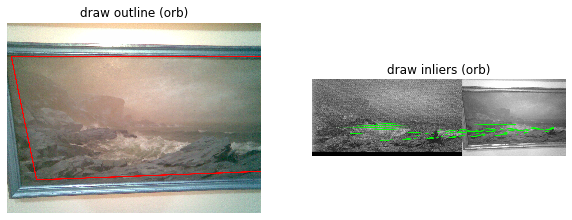

number of detected inliers:  52
number of detected outliers:  9.0
Ratio:  0.8524590163934426


In [189]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_orb = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)


# draw inliers
inliers_orb = draw_inliers(img1, img2, kp1, kp2, good_orb_without_list, matchesMask)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_orb)
ax1.set_axis_off()
ax1.set_title('draw outline (orb)')

ax2.imshow(inliers_orb)
ax2.set_axis_off()
ax2.set_title('draw inliers (orb)')

plt.show()



inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Draw outlines and inliers (using sift)

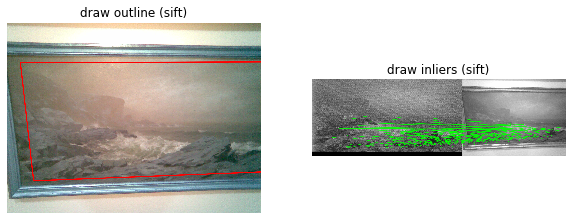

number of detected inliers:  142
number of detected outliers:  48.0
Ratio:  0.7473684210526316


In [190]:
src_pts = np.float32([kp3[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp4[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

# draw inliers
inliers_sift = draw_inliers(img1, img2, kp3, kp4, good_sift_without_list, matchesMask)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_sift)
ax1.set_axis_off()
ax1.set_title('draw outline (sift)')

ax2.imshow(inliers_sift)
ax2.set_axis_off()
ax2.set_title('draw inliers (sift)')

plt.show()






inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Summary

**Ratio = number of inlier/number of matches**

I compare the ratio of two method (orb and sift), when the ratio become smaller (should bigger than 0), the ouline will become more acurrate. By compare ***picture draw outline (orb)*** and ***picture draw outline (sift)***, we can see the **picture draw outline (sift)** works better. By the way, the ratio is 0.747 (sift method) which is smaller than 0.852 (orb method).

***

# What am I looking at? (40%)

In [79]:
# load files in the folder
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), 0)
        if img is not None:
            images.append(img)
    return images

In [80]:
def match_book(method):
    book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
    book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

    # list = []
    count = 0
    for y in range(0,100):
        list = []
        q_kp, q_des = detectAndDescribe(book_Q[y], method)
        for x in range(0, 100):
            kp, des = detectAndDescribe(book_ref[x], method)

            bf_sift = createMatcher(method)
            matches_sift = bf_sift.knnMatch(des, q_des, k=2) 

            good_sift = []
            good_sift_without_list = []
            for m,n in matches_sift:
                if m.distance < 0.8 * n.distance:
                    good_sift.append([m])
                    good_sift_without_list.append(m)
        
            if len(good_sift_without_list) > 4:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
                dst_pts = np.float32([q_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

                model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
                inliers_number = np.sum(matchesMask)
                list.append(inliers_number)
            else:
                list.append(0)
    
        max_value = max(list)
        # min_value = min(list)
        index = list.index(max_value)

        if index == y:  
            count += 1
            # print ("The number", y, "image is the best, it has best score :", max_value, "(points matches).")
            
    return count

In [81]:
import heapq

def match_book_k(k, method):
    book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
    book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

    # list = []
    count = 0
    for y in range(0,100):
        list = []
        q_kp, q_des = detectAndDescribe(book_Q[y], method)
        for x in range(0, 100):
            kp, des = detectAndDescribe(book_ref[x], method)

            bf_sift = createMatcher(method)
            matches_sift = bf_sift.knnMatch(des, q_des, k=2) 

            good_sift = []
            good_sift_without_list = []
            for m,n in matches_sift:
                if m.distance < 0.8 * n.distance:
                    good_sift.append([m])
                    good_sift_without_list.append(m)
        
            if len(good_sift_without_list) > 4:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
                dst_pts = np.float32([q_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

                model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
                inliers_number = np.sum(matchesMask)
                list.append(inliers_number)
            else:
                list.append(0)

        value = heapq.nlargest(k, list)

        # print(value)
        for i in value:
            index = list.index(i)

            if y == index:
                count += 1
                break

    return count

In [82]:
def match_book_resize(k, factor, method):
    book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
    book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

    # list = []
    count = 0
    for y in range(0,100):
        list = []
        book_Q[y] = cv2.resize(book_Q[y], (0,0), fx=factor, fy=factor)
        q_kp, q_des = detectAndDescribe(book_Q[y], method)
        for x in range(0, 100):
            kp, des = detectAndDescribe(book_ref[x], method)

            bf_sift = createMatcher(method)
            matches_sift = bf_sift.knnMatch(des, q_des, k=2) 

            good_sift = []
            good_sift_without_list = []
            for m,n in matches_sift:
                if m.distance < 0.8 * n.distance:
                    good_sift.append([m])
                    good_sift_without_list.append(m)
        
            if len(good_sift_without_list) > 4:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
                dst_pts = np.float32([q_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

                model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
                inliers_number = np.sum(matchesMask)
                list.append(inliers_number)
            else:
                list.append(0)

        value = heapq.nlargest(k, list)

        # print(value)
        for i in value:
            index = list.index(i)

            if y == index:
                count += 1
                break

    return count

In [83]:
def match_painting(k, method):
    book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/museum_paintings/Reference')
    book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/museum_paintings/Query')

    # list = []
    count = 0
    for y in range(0,90):
        list = []
        q_kp, q_des = detectAndDescribe(book_Q[y], method)
        for x in range(0, 90):
            kp, des = detectAndDescribe(book_ref[x], method)

            bf_sift = createMatcher(method)
            matches_sift = bf_sift.knnMatch(des, q_des, k=2) 

            good_sift = []
            good_sift_without_list = []
            for m,n in matches_sift:
                if m.distance < 0.8 * n.distance:
                    good_sift.append([m])
                    good_sift_without_list.append(m)
        
            if len(good_sift_without_list) > 4:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
                dst_pts = np.float32([q_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

                model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
                inliers_number = np.sum(matchesMask)
                list.append(inliers_number)
            else:
                list.append(0)

        value = heapq.nlargest(k, list)

        # print(value)
        for i in value:
            index = list.index(i)

            if y == index:
                count += 1
                break

    return count

## Using orb

***Example --> this case is one of a suucessful cases (book_covers 12) :***

In [84]:
# Your code to iddntify query objects and measure search accuracy for data set here 
book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/012.jpg', 0)
# book_test = cv2.resize(book_test, (0,0), fx=0.5, fy=0.5)
test_kp, test_des = detectAndDescribe(book_test, 'orb')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'orb')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('orb')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)
        
    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)
    else:
        list.append(0)

max_value = max(list)
index = list.index(max_value)

# print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

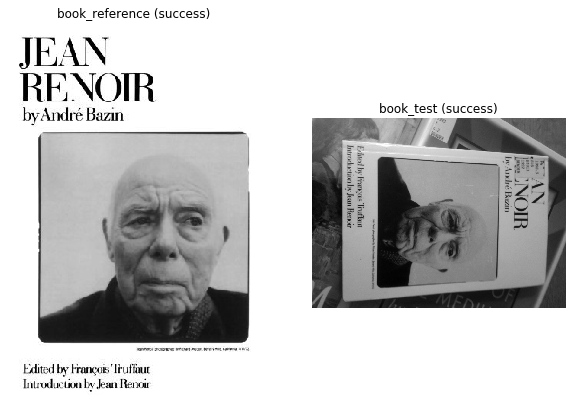

In [85]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(book_ref[index])
ax1.set_axis_off()
ax1.set_title('book_reference (success)')

ax2.imshow(book_Q[index])
ax2.set_axis_off()
ax2.set_title('book_test (success)')

plt.show()

***Example --> this case is one of a failed cases (book_covers 59) :***

In [86]:
# Your code to iddntify query objects and measure search accuracy for data set here 
book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/059.jpg', 0)
# book_test = cv2.resize(book_test, (0,0), fx=0.5, fy=0.5)
test_kp, test_des = detectAndDescribe(book_test, 'orb')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'orb')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('orb')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)
    else:
        list.append(0)

max_value = max(list)
index = list.index(max_value)

# print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

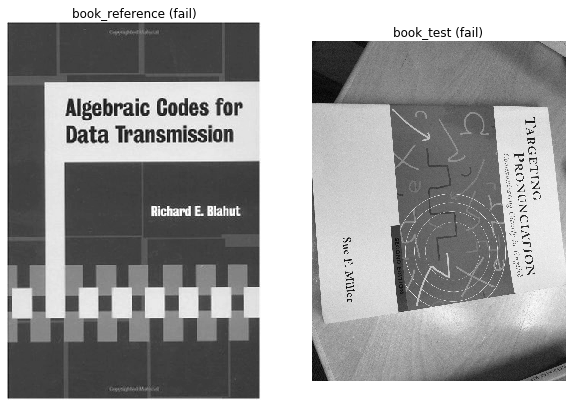

In [87]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(book_ref[index])
ax1.set_axis_off()
ax1.set_title('book_reference (fail)')

ax2.imshow(book_test)
ax2.set_axis_off()
ax2.set_title('book_test (fail)')

plt.show()

### Result -- use orb （some examples)

***test case : 01, 12, 13, 23, 59, 73, 56, 89, 46, 81, 86 (random select)***

**The details are :**
 
    
    ** case ******* score ********* result **

    image 01         100            success

    image 12         56             success

    image 13         54             success

    image 23         48             success

    image 59         11             fail

    image 73         13             fail

    image 56         12             fail

    image 89         9              fail

    image 46         9              fail

    image 81         23             success

    image 86         20             success


### Summary

In [88]:
number_orb = match_book('orb')

print("numbers of pairs (orb): ", number_orb)
print("accuracy (orb): ", number_orb/101 * 100, "%")

numbers of pairs (orb):  66
accuracy (orb):  65.34653465346535 %


In [89]:
number_orb_k = match_book_k(5, 'orb')

In [90]:
print("numbers of pairs (orb + top-5): ", number_orb_k)
print("accuracy (orb + top-5): ", number_orb_k/101 * 100, "%")

numbers of pairs (orb + top-5):  70
accuracy (orb + top-5):  69.3069306930693 %


method we used :

- image size : **orignal**
    
- feature detector : **orb**
    
- matching strategy : **KNN**


**Total Accuracy : 65.3465%  --> (66/101)**

**Total Accuracy (top-5): 69.3069%  --> (70/101)**


Through apply the top-k accuracy method, we get a higher accuracy, it increase almost **4%**! (from 65.3% to 69.3%)

***

## Using sift

***Example --> this case is one of a sucessful cases (book_covers 89)***

In [91]:

book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/089.jpg', 0)
# book_test = cv2.add(book_test, 30)
test_kp, test_des = detectAndDescribe(book_test, 'sift')



# Your code to iddntify query objects and measure search accuracy for data set here 

book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/089.jpg', 0)
# book_test = cv2.add(book_test, 30)
test_kp, test_des = detectAndDescribe(book_test, 'sift')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'sift')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('sift')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)
    else:
        list.append(0)

max_value = max(list)
index = list.index(max_value)

# print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

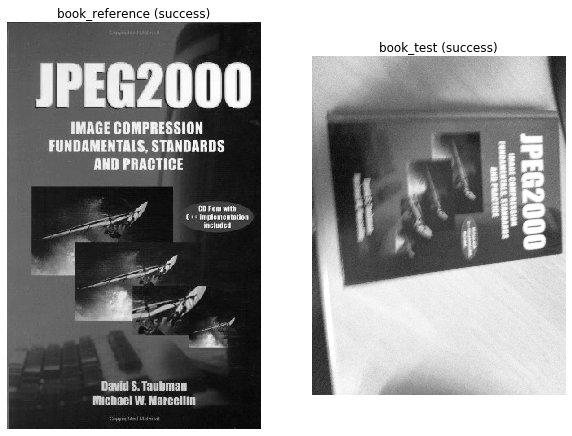

In [92]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(book_ref[index])
ax1.set_axis_off()
ax1.set_title('book_reference (success)')

ax2.imshow(book_test)
ax2.set_axis_off()
ax2.set_title('book_test (success)')

plt.show()

### Result -- use sift  (some examples)


***test case : 01, 12, 13, 23, 59, 73, 56, 89, 46, 81, 86 (randomly select)***


**The details are (some cases) :**
 
    
    ** case ******* score ********* result **

    image 01         127            success

    image 12         163            success

    image 13         411            success

    image 23         30             fail

    image 59         138            success

    image 73         160            success

    image 56         320            success

    image 89         52             success

    image 46         154            success

    image 81         155            success

    image 86         120            success

### Summary

In [93]:
number_sift = match_book('sift')

print("numbers of pairs (sift): ", number_sift)
print("accuracy (sift): ", number_sift/101 * 100 , "%")

numbers of pairs (sift):  93
accuracy (sift):  92.07920792079209 %


In [95]:
number_sift_k = match_book_k(5, 'sift')

In [96]:
print("numbers of pairs (sift + top-5): ", number_sift_k)
print("accuracy (sift + top-5): ", number_sift_k/101 * 100 , "%")

numbers of pairs (sift + top-5):  98
accuracy (sift + top-5):  97.02970297029702 %


what we used :

- image size : **orignal**
    
- feature detector : **sift**
    
- matching strategy : **KNN**

**Total Accuracy : 92.0792%  -->  (93/101)**

**Total Accuracy (top-5): 97.0297%  -->  (98/101)**

When we use top-5 accuracy to measuer, we can get a high accuracy with sift method. It increase **4.95%**. (from 92.08% to 97.03%)

I change the moethod of **feature detector**, from orb method to sift method. It works good and the accuracy increase almost **27.7%** (from 69.3% to 97%).

**Small thing :**

- However, I discover that the image (book_covers 23) failed in sift method (which has a high accuracy), success in the orb method (which has a low accuracy).

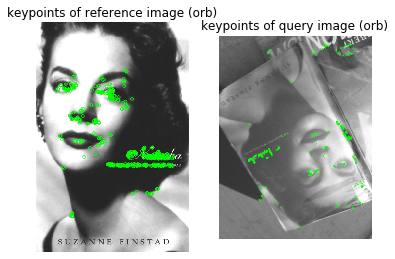

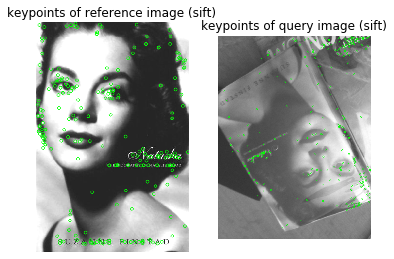

In [97]:
# load image at gray scale
img1 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference/023.jpg', 0)
img2 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/023.jpg', 0)
img1 = cv2.add(img1, 30)
img2 = cv2.add(img2, 30)

# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(6, 7))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image_orb)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')

# print(kp1)

# use sift
kp3, des3 = detectAndDescribe(img1, 'sift')
kp4, des4 = detectAndDescribe(img2, 'sift')

reference_image_sift = cv2.drawKeypoints(img1, kp3, des3, color=(0,255,0), flags=0)
query_image_sift = cv2.drawKeypoints(img2, kp4, des4, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(6, 7))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_sift)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (sift)')

ax2.imshow(query_image_sift)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (sift)')


plt.show()

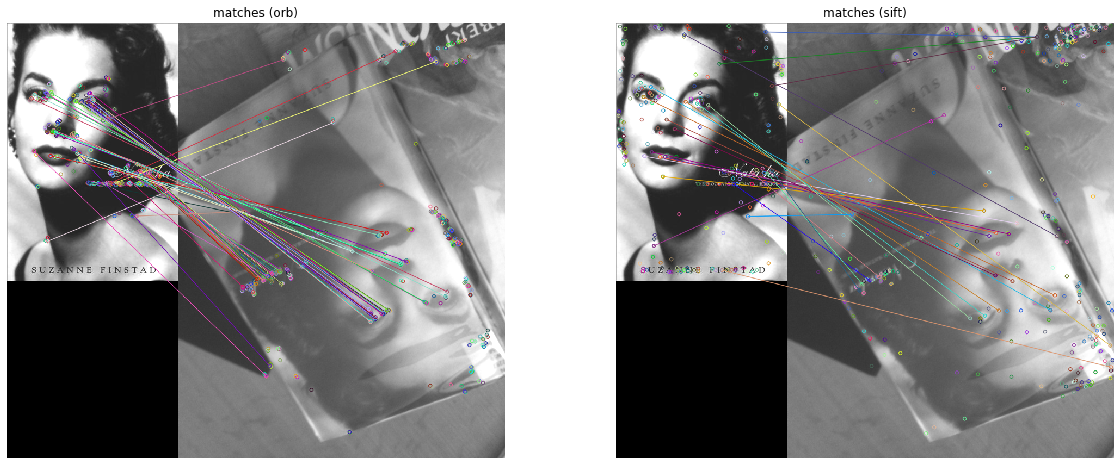

In [98]:
bf_orb = createMatcher('orb')
bf_sift = createMatcher('sift')

matches_orb = bf_orb.knnMatch(des1, des2, k=2) 
matches_sift = bf_sift.knnMatch(des3, des4, k=2) 

# Apply ratio test (orb)
good_orb = []
good_orb_without_list = []
for m,n in matches_orb:
    if m.distance < 0.8 * n.distance:
        good_orb.append([m])
        good_orb_without_list.append(m)


# Apply ratio test (sift)
good_sift = []
good_sift_without_list = []
for m,n in matches_sift:
    if m.distance < 0.8 * n.distance:
        good_sift.append([m])
        good_sift_without_list.append(m)

# draw matches
matches_orb = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_orb, None)
matches_sift = cv2.drawMatchesKnn(img1, kp3, img2, kp4, good_sift, None)

fig = plt.figure(figsize=(20, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(matches_orb)
ax1.set_axis_off()
ax1.set_title('matches (orb)')

ax2.imshow(matches_sift)
ax2.set_axis_off()
ax2.set_title('matches (sift)')

plt.show()

From the images (macthes (orb), matches (sift)), we can see orb method works better than the sift method in finding keypoints in objects, but in finding keypoints in text area, sift method works better. 

### Summary

After searching the internet, I discover that the difference between ORB and SIFT method. 

**ORB:** It computes the intensity weighted centroid of the patch with located corner at center.

In case(book_covers 023), we can see the reference image shows a strong intensity contrast. So I think this is a reason that orb works better.

So I get an idea that if we resize the image or change the brightness then use orb method, would the accuracy increase?

***

## Changing the size (using orb)

***Example --> this case is one of a sucessful cases (book_covers 12)***

In [99]:
# Your code to iddntify query objects and measure search accuracy for data set here 
book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/012.jpg', 0)
book_test = cv2.resize(book_test, (0,0), fx=0.5, fy=0.5)
test_kp, test_des = detectAndDescribe(book_test, 'orb')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'orb')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('orb')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)
    else:
        list.append(0)

max_value = max(list)
index = list.index(max_value)

# print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

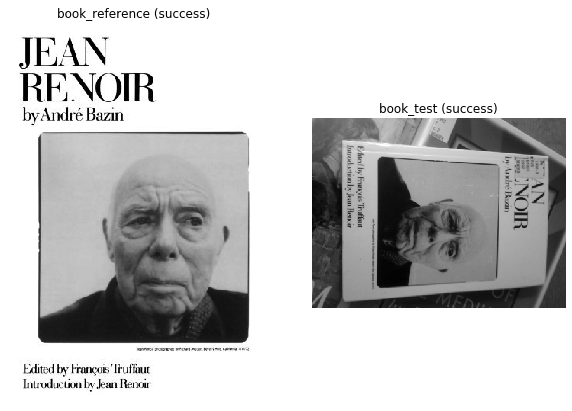

In [100]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(book_ref[index])
ax1.set_axis_off()
ax1.set_title('book_reference (success)')

ax2.imshow(book_test)
ax2.set_axis_off()
ax2.set_title('book_test (success)')

plt.show()

### Result -- change size with factor 0.5 (some examples)

***test case : 01, 12, 13, 23, 59, 73, 56, 89, 46, 81, 86 (random select)***

**The details are :**
 
    
    ** case ******* score ********* result **

    image 01         142            success

    image 12         53             success 

    image 13         71             success

    image 23         54             success

    image 59         44             success

    image 73         47             success

    image 56         68             success

    image 89         26             success

    image 46         19             success

    image 81         115            success

    image 86         48             success

### Summary

In [101]:
number_resize = match_book_resize(5, 0.3, 'orb')

print("numbers of successful pairs (resize - 0.3) :", number_resize)
print("accuracy :", number_resize/101 * 100, "%")

numbers of successful pairs (resize - 0.3) : 94
accuracy : 93.06930693069307 %


In [102]:
number_resize = match_book_resize(5, 0.5, 'orb')

print("numbers of successful pairs (resize - 0.5) :", number_resize)
print("accuracy :", number_resize/101 * 100, "%")

numbers of successful pairs (resize - 0.5) : 96
accuracy : 95.04950495049505 %


In [103]:
number_resize = match_book_resize(5, 0.8, 'orb')

print("numbers of successful pairs (resize - 0.8) :", number_resize)
print("accuracy :", number_resize/101 * 100, "%")

numbers of successful pairs (resize - 0.8) : 90
accuracy : 89.10891089108911 %


what we used :

- image size : **0.3, 0.5, 0.8**
    
- feature detector : **orb**
    
- matching strategy : **KNN**

**Total Accuracy(with factor 0.3 + top-5): 93.0693%  --> (94/101)**

**Total Accuracy(with factor 0.5 + top-5): 95.0495%  --> (96/101)**

**Total Accuracy(with factor 0.8 + top-5): 89.1089%  --> (90/101)**

When we resize the book covers with factor 0.5, the accuracy is become 95.0693%. Compare to use the orb method without resziing, the accuracy increase **35.74%** (from 69.31% to 95.05%) after resize the image size. 

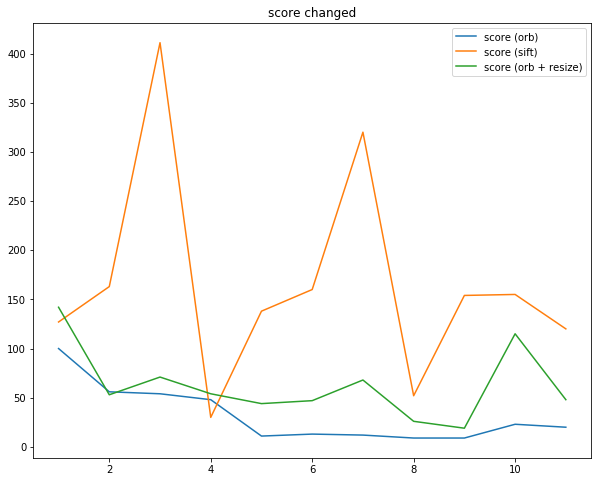

In [104]:
import matplotlib.pyplot as plt
 
# x  = [1, 12, 13, 23, 59, 73, 56, 89, 46, 81, 86]
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

y1 = [100, 56, 54, 48, 11, 13, 12, 9, 9, 23, 20]
y2 = [127, 163, 411, 30, 138, 160, 320, 52, 154, 155, 120]
y3 = [142, 53, 71, 54, 44, 47, 68, 26, 19, 115, 48]
plt.plot(x, y1, label="score (orb)")
plt.plot(x, y2, label="score (sift)")
plt.plot(x, y3, label="score (orb + resize)")
plt.plot()

# plt.xlabel("image")
# plt.ylabel("score")
plt.title("score changed")
plt.legend()
plt.show()

From the image, we can clearly see that sift method works perfect (expect some cases). However, when we use orb method, resize the image with factor 0.5 can increase the score. It helps a lot.

### Discuss

Here we discuss a case which fail in the original size but success after resizing.

Let's see what differnece between resize and the orignal size.

**Here is a case book_covers 046 --> which fail in the original size but success after resizing**

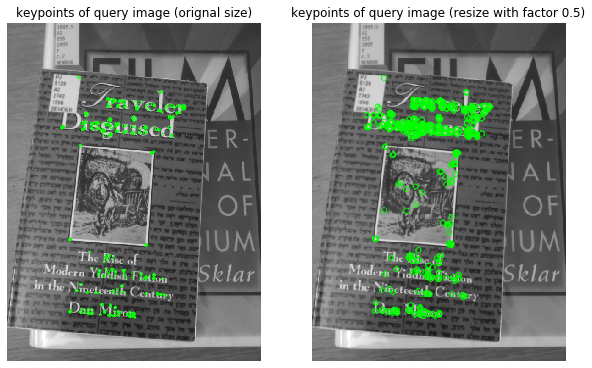

In [105]:
# load image at gray scale
img1 = cv2.imread('A2_smvs/book_covers/Query/046.jpg', 0)
img2 = cv2.resize(img1, (0,0), fx=0.5, fy=0.5)

# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of query image (orignal size)')

ax2.imshow(query_image_orb)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (resize with factor 0.5)')

plt.show()

Compare these two iamges, we can see the key points **increase** a lot when after we resize the image, espically in text area. It is the main reason we can success.

***

# Not in the data set

In [106]:
def match_book_value(method):
    book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
    book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

    # list = []
    count = 0
    for y in range(0,100):
        list = []
        q_kp, q_des = detectAndDescribe(book_Q[y], method)
        for x in range(0, 100):
            kp, des = detectAndDescribe(book_ref[x], method)

            bf_sift = createMatcher(method)
            matches_sift = bf_sift.knnMatch(des, q_des, k=2) 

            good_sift = []
            good_sift_without_list = []
            for m,n in matches_sift:
                if m.distance < 0.8 * n.distance:
                    good_sift.append([m])
                    good_sift_without_list.append(m)
        
            if len(good_sift_without_list) > 4:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
                dst_pts = np.float32([q_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

                model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
                inliers_number = np.sum(matchesMask)
                list.append(inliers_number)
            # else:
                # list.append(0)
        
        list.sort()
        # max_value = max(list)
        min_value = list[0]
       
    return list

## Using orb

In [107]:
# Your code to iddntify query objects and measure search accuracy for data set here 

book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/no reference set/5.jpg', 0)
book_test = cv2.add(book_test, 20)
test_kp, test_des = detectAndDescribe(book_test, 'orb')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'orb')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('orb')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)
    else:
        list.append(0)

max_value = max(list)
index = list.index(max_value)


# method to test:
 
# if max_value < 13:
#     print("not in the set")
# else:
#     print("in the set")

**Result -- using orb**

***test case : 01, 02, 03, 04, 05, 06, 07, 08, 09***

**Accuracy : 77.78%  -->   7/9**

**The details are :**
 
    
    ** case ******* score ************* result **

    image 01          N             not in the set 

    image 02          N             not in the set

    image 03          N             not in the set

    image 04          N             not in the set

    image 05          25                success

    image 06          N             not in the set

    image 07          28                success

    image 08          N             not in the set

    image 09          N             not in the set

### Summary

What we used :

- image size : **original**

- image brightness : **original**
    
- feature detector : **orb**
    
- matching strategy : **KNN**

I set a value (13) to the threshold, and the accuracy is **77.78%**. 

If the threshold is smaller than the threshold, I identify it is not in the data set. If the threshold is larger than the threshold, I identify it is in the data set.

***

## Using sift

In [ ]:
# Your code to iddntify query objects and measure search accuracy for data set here 

book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/no reference set/3.jpg', 0)
book_test = cv2.add(book_test, 20)
test_kp, test_des = detectAndDescribe(book_test, 'sift')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'sift')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('sift')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)
    else:
        list.append(0)

max_value = max(list)
index = list.index(max_value)

# method to test:
 
# if max_value < 52:
#     print("not in the set")
# else:
#     print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

**Result -- using sift**

***test case : 01, 02, 03, 04, 05, 06, 07, 08, 09***

**Accuracy : 77.78%  -->  (7/9)**

**The details are :**
 
    
    ** case ******* score ************ result **

    image 01          N             not in the set 

    image 02         69               success

    image 03         157              success

    image 04          N             not in the set

    image 05          N             not in the set

    image 06          N             not in the set

    image 07          N             not in the set

    image 08          N             not in the set

    image 09          N             not in the set

### Summary

What we used :

- image size : **original**

- image brightness : **original**
    
- feature detector : **sift**
    
- matching strategy : **KNN**

I set a value (52) to the threshold, and the accuracy is still **77.78%**. 

If the threshold is smaller than the threshold, I identify it is not in the data set. If the threshold is larger than the threshold, I identify it is in the data set.

***

## Change the brightness

In [ ]:
# Your code to iddntify query objects and measure search accuracy for data set here 
book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
# modify the file name here
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/no reference set/3.jpg', 0)

# book_test = cv2.resize(book_test, (0,0), fx=0.5, fy=0.5)
book_test = cv2.add(book_test, 20)

test_kp, test_des = detectAndDescribe(book_test, 'orb')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    # book_ref[x] = cv2.resize(book_ref[x], (0,0), fx=0.5, fy=0.5)
    book_ref[x] = cv2.add(book_ref[x], 20)
    kp, des = detectAndDescribe(book_ref[x], 'orb')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('orb')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)
    else:
        list.append(0)

max_value = max(list)
index = list.index(max_value)


# method to test:
 
# if max_value < 13:
#     print("not in the set")
# else:
#     print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

**Result -- change the brightness**

***test case : 01, 02, 03, 04, 05, 06, 07, 08, 09***

**Accuracy : 100.00%  -->  (9/9)**

**The details are :**
 
    
    ** case ******* score ************ result **

    image 01          N             not in the set 

    image 02          N             not in the set 

    image 03          N             not in the set

    image 04          N             not in the set

    image 05          N             not in the set

    image 06          N             not in the set

    image 07          N             not in the set

    image 08          N             not in the set

    image 09          N             not in the set

#### Summary

What we used :

- image size : **original**

- image brightness : **add 20**
    
- feature detector : **orb**
    
- matching strategy : **KNN**

I change the **image brightness**. And I set a value (13) to the threshold, and the accuracy is **100%**! 

If the threshold is smaller than the threshold, I identify it is not in the data set. If the threshold is larger than the threshold, I identify it is in the data set.

***

# Landmarks

## In data set

In [124]:
import heapq

def match_landmark(k, method):
    book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/landmarks/Reference')
    book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/landmarks/Query')

    # list = []
    count = 0
    for y in range(0,100):
        list = []
        q_kp, q_des = detectAndDescribe(book_Q[y], method)
        for x in range(0, 100):
            kp, des = detectAndDescribe(book_ref[x], method)

            bf_sift = createMatcher(method)
            matches_sift = bf_sift.knnMatch(des, q_des, k=2) 

            good_sift = []
            good_sift_without_list = []
            for m,n in matches_sift:
                if m.distance < 0.8 * n.distance:
                    good_sift.append([m])
                    good_sift_without_list.append(m)
        
            if len(good_sift_without_list) > 4:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
                dst_pts = np.float32([q_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

                model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
                inliers_number = np.sum(matchesMask)
                list.append(inliers_number)
            else:
                list.append(0)

        value = heapq.nlargest(k, list)

        # print(value)
        for i in value:
            index = list.index(i)

            if y == index:
                count += 1
                break

    return count

In [130]:
import heapq

def show_match_landmark(k, method):
    book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/landmarks/Reference')
    book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/landmarks/Query')

    # list = []
    count = 0
    for y in range(0,100):
        list = []
        q_kp, q_des = detectAndDescribe(book_Q[y], method)
        for x in range(0, 100):
            kp, des = detectAndDescribe(book_ref[x], method)

            bf_sift = createMatcher(method)
            matches_sift = bf_sift.knnMatch(des, q_des, k=2) 

            good_sift = []
            good_sift_without_list = []
            for m,n in matches_sift:
                if m.distance < 0.8 * n.distance:
                    good_sift.append([m])
                    good_sift_without_list.append(m)
        
            if len(good_sift_without_list) > 4:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
                dst_pts = np.float32([q_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

                model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
                inliers_number = np.sum(matchesMask)
                list.append(inliers_number)
            else:
                list.append(0)

        value = heapq.nlargest(k, list)

        # print(value)
        for i in value:
            index = list.index(i)

            if y == index:
                print(index, "is the best with score:", i)

    # return count

### Using orb method

In [126]:
number_orb = match_landmark(5, 'orb')

print("numbers of pairs (orb): ", number_orb)
print("accuracy (orb): ", number_orb/101 * 100 , "%")

numbers of pairs (orb):  28
accuracy (orb):  27.722772277227726 %


***Total Accuracy : 27.72% --> (28/101)***

***

### Using sift method

In [132]:
number_sift = match_landmark(5, 'sift')

print("numbers of pairs (sift): ", number_sift)
print("accuracy (sift): ", number_sift/101 * 100 , "%")

numbers of pairs (sift):  31
accuracy (sift):  30.693069306930692 %


***Total Accuracy : 30.69% --> (31/101)***

***

### Discuss --> landmarks_018

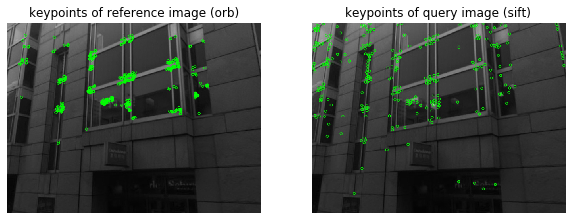

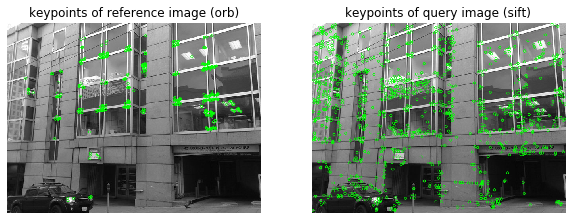

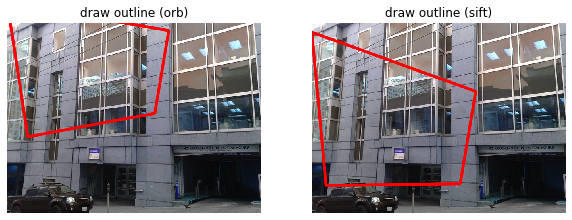

In [203]:
img1 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/landmarks/Reference/018.jpg', 0)
# img1 = cv2.add(img1, 100)
# img1 = cv2.resize(img1, (0,0), fx=0.7, fy=0.7)
img2 = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/landmarks/Query/018.jpg', 0)

color_query = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/landmarks/Query/018.jpg')


# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)


# use sift
kp3, des3 = detectAndDescribe(img1, 'sift')
kp4, des4 = detectAndDescribe(img2, 'sift')

reference_image_sift = cv2.drawKeypoints(img1, kp3, des3, color=(0,255,0), flags=0)
query_image_sift = cv2.drawKeypoints(img2, kp4, des4, color=(0,255,0), flags=0)

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(reference_image_sift)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (sift)')


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(query_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image_sift)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (sift)')

plt.show()

bf_orb = createMatcher('orb')
bf_sift = createMatcher('sift')

matches_orb = bf_orb.knnMatch(des1, des2, k=2) 
matches_sift = bf_sift.knnMatch(des3, des4, k=2) 

# Apply ratio test (orb)
good_orb = []
good_orb_without_list = []
for m,n in matches_orb:
    if m.distance < 0.8 * n.distance:
        good_orb.append([m])
        good_orb_without_list.append(m)

# Apply ratio test (sift)
good_sift = []
good_sift_without_list = []
for m,n in matches_sift:
    if m.distance < 0.8 * n.distance:
        good_sift.append([m])
        good_sift_without_list.append(m)

src_pts = np.float32([kp3[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp4[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)


src_pts_orb = np.float32([kp1[m.queryIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)
dst_pts_orb = np.float32([kp2[m.trainIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)

model1, matchesMask1 = cv2.findHomography(src_pts_orb, dst_pts_orb, cv2.RANSAC, 5.0)

# draw outline
dst1 = draw_outline(img1, color_query, model1) 

img = color_query.copy()
outline_orb = cv2.polylines(img,[np.int32(dst1)],True,255,5,cv2.LINE_AA)



fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_orb)
ax1.set_axis_off()
ax1.set_title('draw outline (orb)')

ax2.imshow(outline_sift)
ax2.set_axis_off()
ax2.set_title('draw outline (sift)')

plt.show()

In this case, we can see if we use orb, it fails. However, if we use sift, we can get the correct area. In dectecting key points part, we can see orb method can not detect many key points below the windows (including the wall and the signage). So we can not get the correct area when we use orb mehod because of the poor quantity of key points.

## Not in data set

# GMS and ratio_test (10%)

## Book covers

**case: book_covers 025**

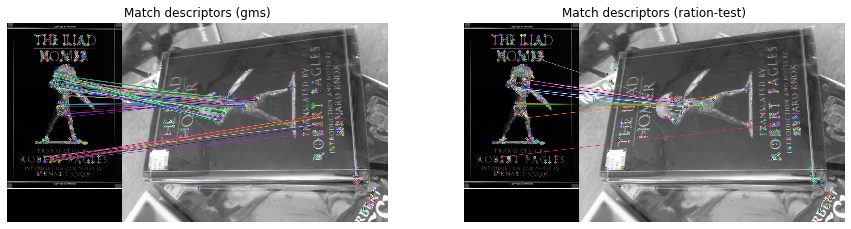

In [ ]:
img1 = cv2.imread('A2_smvs/book_covers/Reference/025.jpg', 0)
img2 = cv2.imread('A2_smvs/book_covers/Query/025.jpg', 0)
color_query = cv2.imread('A2_smvs/book_covers/Query/025.jpg')


# compute detector and descriptor
orb = cv2.ORB_create(1000,fastThreshold=0)

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

dim=img1.shape[:2]
dim=(dim[1],dim[0])

bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
bf2 = cv2.BFMatcher(cv2.NORM_HAMMING)

matches = bf.match(des1, des2)
matches_knn = bf2.knnMatch(des1, des2, k=2)

good = []
good_without_list = []
for m,n in matches_knn:
    if m.distance < 0.5 * n.distance:
        good.append([m])  
        good_without_list.append(m)

# draw matches
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None)

matches = cv2.xfeatures2d.matchGMS(dim,dim,kp1,kp2,matches,withRotation=True,withScale=True)

img4 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(img4)
ax1.set_axis_off()
ax1.set_title('Match descriptors (gms)')

ax2.imshow(img3)
ax2.set_axis_off()
ax2.set_title('Match descriptors (ration-test)')


plt.show()


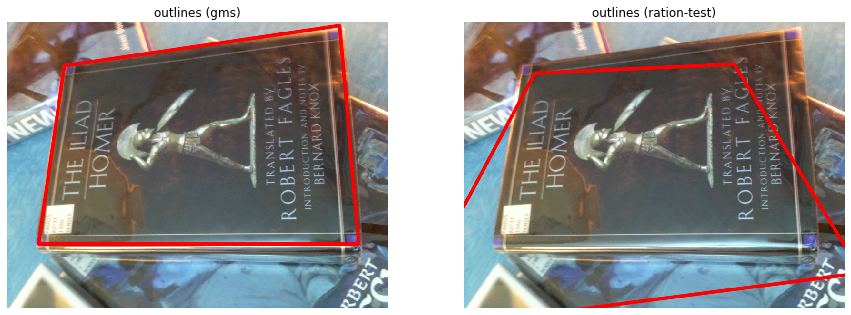

In [ ]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

src_pts2 = np.float32([kp1[m.queryIdx].pt for m in good_without_list]).reshape(-1,1,2)
dst_pts2 = np.float32([kp2[m.trainIdx].pt for m in good_without_list]).reshape(-1,1,2)


model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
model2, matchesMask2 = cv2.findHomography(src_pts2, dst_pts2, cv2.RANSAC,5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 
dst2 = draw_outline(img1, color_query, model2) 

img = color_query.copy()
img2 = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)
outline_sift2 = cv2.polylines(img2,[np.int32(dst2)],True,255,5,cv2.LINE_AA)

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_sift)
ax1.set_axis_off()
ax1.set_title('outlines (gms)')

ax2.imshow(outline_sift2)
ax2.set_axis_off()
ax2.set_title('outlines (ration-test)')

plt.show()


### Discovery

At first time, I set numbers of features be **10,000**, GMS and ratio-test method all returns correct outlines. However, when I set number of features be **1000**, GMS do better than the ratio-test method.

***

## Landmarks

**case: landmarks 0000**

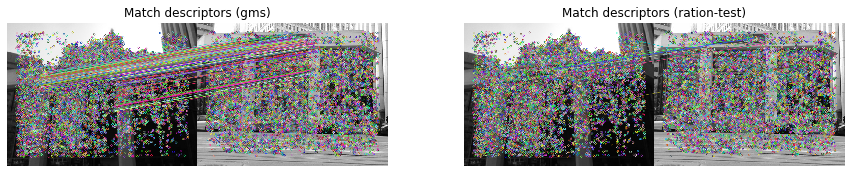

In [185]:
img1 = cv2.imread('A2_smvs/landmarks/Reference/0000.jpg', 0)
img2 = cv2.imread('A2_smvs/landmarks/Query/0000.jpg', 0)
color_query = cv2.imread('A2_smvs/landmarks/Query/0000.jpg')


# compute detector and descriptor
orb = cv2.ORB_create(20000,fastThreshold=0)

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

dim=img1.shape[:2]
dim=(dim[1],dim[0])

bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
bf2 = cv2.BFMatcher(cv2.NORM_HAMMING)

matches = bf.match(des1, des2)
matches_knn = bf2.knnMatch(des1, des2, k=2)

good = []
good_without_list = []
for m,n in matches_knn:
    if m.distance < 0.5 * n.distance:
        good.append([m])  
        good_without_list.append(m)

# draw matches
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None)

matches = cv2.xfeatures2d.matchGMS(dim,dim,kp1,kp2,matches,withRotation=True,withScale=True)

img4 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(img4)
ax1.set_axis_off()
ax1.set_title('Match descriptors (gms)')

ax2.imshow(img3)
ax2.set_axis_off()
ax2.set_title('Match descriptors (ration-test)')


plt.show()


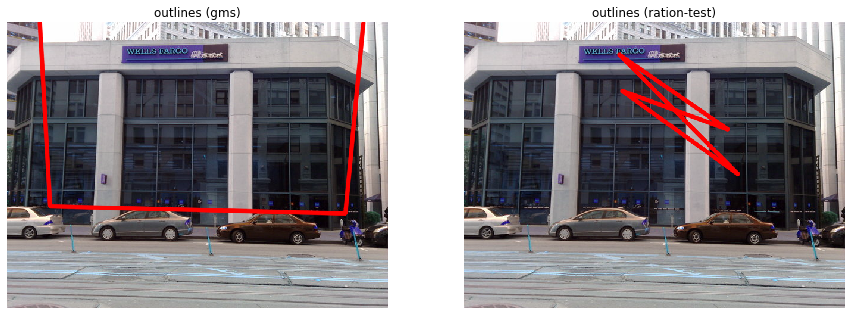

In [186]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

src_pts2 = np.float32([kp1[m.queryIdx].pt for m in good_without_list]).reshape(-1,1,2)
dst_pts2 = np.float32([kp2[m.trainIdx].pt for m in good_without_list]).reshape(-1,1,2)


model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
model2, matchesMask2 = cv2.findHomography(src_pts2, dst_pts2, cv2.RANSAC,5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 
dst2 = draw_outline(img1, color_query, model2) 

img = color_query.copy()
img2 = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)
outline_sift2 = cv2.polylines(img2,[np.int32(dst2)],True,255,5,cv2.LINE_AA)

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_sift)
ax1.set_axis_off()
ax1.set_title('outlines (gms)')

ax2.imshow(outline_sift2)
ax2.set_axis_off()
ax2.set_title('outlines (ration-test)')

plt.show()


### Discovery

At first time, I set numbers of features be **20,000**, we can easily see that GMS works better than the ration-test.

***

## Museum paintings

**case: museum_paintings 055**

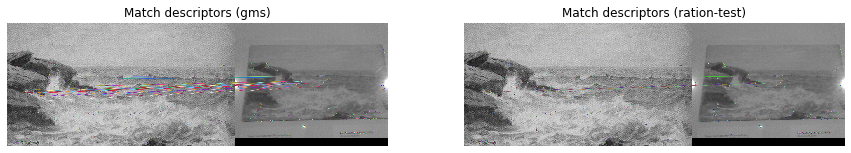

In [ ]:
img1 = cv2.imread('A2_smvs/museum_paintings/Reference/055.jpg', 0)
img2 = cv2.imread('A2_smvs/museum_paintings/Query/055.jpg', 0)
color_query = cv2.imread('A2_smvs/museum_paintings/Query/055.jpg')


# compute detector and descriptor
orb = cv2.ORB_create(1300,fastThreshold=0)

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

dim=img1.shape[:2]
dim=(dim[1],dim[0])

bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
bf2 = cv2.BFMatcher(cv2.NORM_HAMMING)

matches = bf.match(des1, des2)
matches_knn = bf2.knnMatch(des1, des2, k=2)

good = []
good_without_list = []
for m,n in matches_knn:
    if m.distance < 0.5 * n.distance:
        good.append([m])  
        good_without_list.append(m)

# draw matches
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None)

matches = cv2.xfeatures2d.matchGMS(dim,dim,kp1,kp2,matches,withRotation=True,withScale=True)

img4 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(img4)
ax1.set_axis_off()
ax1.set_title('Match descriptors (gms)')

ax2.imshow(img3)
ax2.set_axis_off()
ax2.set_title('Match descriptors (ration-test)')


plt.show()

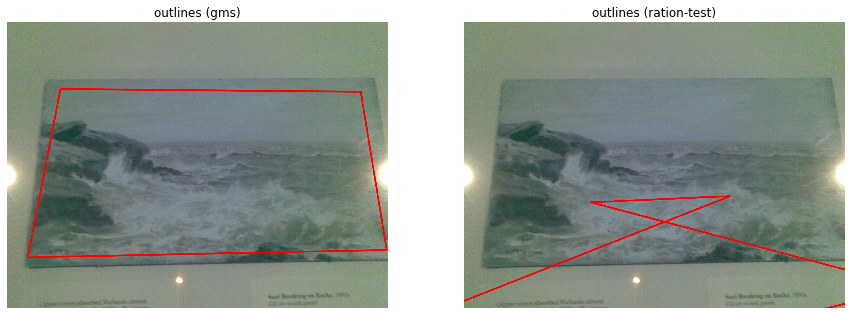

In [ ]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

src_pts2 = np.float32([kp1[m.queryIdx].pt for m in good_without_list]).reshape(-1,1,2)
dst_pts2 = np.float32([kp2[m.trainIdx].pt for m in good_without_list]).reshape(-1,1,2)


model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
model2, matchesMask2 = cv2.findHomography(src_pts2, dst_pts2, cv2.RANSAC,5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 
dst2 = draw_outline(img1, color_query, model2) 

img = color_query.copy()
img2 = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)
outline_sift2 = cv2.polylines(img2,[np.int32(dst2)],True,255,5,cv2.LINE_AA)

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(outline_sift)
ax1.set_axis_off()
ax1.set_title('outlines (gms)')

ax2.imshow(outline_sift2)
ax2.set_axis_off()
ax2.set_title('outlines (ration-test)')

plt.show()

### Discovery

At first time, I set numbers of features be **10,000**, GMS and ratio-test method all returns correct outlines. However, when I set number of features be **1,300**, GMS do better than the ratio-test method.

## Summary

All in all, compare to the GMS and ratio-test, GMS works better if two pictures return same numbers of keypoints. Sometimes, when the numbers of keypoints are limited, GMS works better than the ratio-test because GMS has a better matching strategy.

# Reflection Questions (5%)

- Describe the hardest situation you faced during the first two assignments. And how you overcome it? (3%)

    - The hardest part of assignment 1, I think it is implement the convolution part. The algorithm is quite complex, so I need to learn more about the convolution, I searched a lot in the internet and I get lots of useful information to help me to implement the convolution function. resize function also very tricky, I got mix the width and height.

    - The haradest part of assignment 2, I think it has to explain many reasons and how you get improved. I have to write them step by step with the truth (real data), and test them again and again until I find the correct way to improve. By the way, I have to do lots of research in this part to find some inspirations which can help me.

    - However, I think this process is pretty good because through these two assignments, I can study deeper and make many boring knowledge visualization.


- How do you plan to finish the assignment to meet tight deadline? (2%)

    - I start the assignment when the assignment release, although it takes me a lot of time, but still not feel tight.